In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.naive_bayes import GaussianNB, ComplementNB
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
%matplotlib inline


## Load Data

In [106]:
data = pd.read_csv('data_pre_processed.csv')

In [ ]:
test_set = pd.read_csv(?)

In [75]:
newdata = data.copy()
for i in newdata.columns:
    newdata[i] = newdata[i]+(newdata[i].min()*-1)

In [127]:
newdata.shape

(57996, 112)

# K-Fold Cross-Validation*

In [98]:
K = 5
skf = StratifiedKFold(n_splits=K)

In [105]:
for train, in skf.split(newdata.drop(['thirty_days','one_year'],axis=1).values, newdata.thirty_days.values):
    print(x)
    print(y)

[10949 10950 10953 ... 57993 57994 57995]
[    0     1     2 ... 11732 11733 11734]
[    0     1     2 ... 57993 57994 57995]
[10949 10950 10953 ... 23419 23420 23421]
[    0     1     2 ... 57993 57994 57995]
[21912 21925 21945 ... 35042 35043 35044]
[    0     1     2 ... 57993 57994 57995]
[33183 33203 33215 ... 46534 46535 46536]
[    0     1     2 ... 46534 46535 46536]
[45394 45395 45396 ... 57993 57994 57995]


# Naive Bayes

### Generate Gaussian Model and Fit Data

In [131]:
y30.dtypes

thirty_days    float64
dtype: object

[[5.21929150e-04 9.99478071e-01]
 [1.00000000e+00 3.56772949e-12]
 [9.99999836e-01 1.63728895e-07]
 ...
 [9.99999994e-01 6.29805067e-09]
 [1.00000000e+00 1.48565167e-11]
 [9.99999999e-01 1.05296093e-09]]
[1]
[[1.62169690e-05 9.99983783e-01]
 [1.27168120e-03 9.98728319e-01]
 [1.41656558e-15 1.00000000e+00]
 ...
 [1.00218090e-01 8.99781910e-01]
 [7.34436383e-02 9.26556362e-01]
 [6.90815926e-02 9.30918407e-01]]
[1]
[[9.99992020e-01 7.97982063e-06]
 [9.99993406e-01 6.59430170e-06]
 [9.12606347e-01 8.73936529e-02]
 ...
 [1.00000000e+00 4.39868600e-18]
 [1.00000000e+00 6.13267513e-12]
 [9.99999994e-01 5.68043204e-09]]
[0]
[[9.99998516e-001 1.48427034e-006]
 [6.06552056e-210 1.00000000e+000]
 [6.76000255e-001 3.23999745e-001]
 ...
 [4.31523416e-004 9.99568477e-001]
 [6.22564677e-005 9.99937744e-001]
 [9.99998503e-001 1.49733271e-006]]
[0]
[[1.65977681e-02 9.83402232e-01]
 [7.14251326e-03 9.92857487e-01]
 [7.10605246e-03 9.92893948e-01]
 ...
 [2.61532661e-04 9.99738467e-01]
 [9.99726844e-01 2.

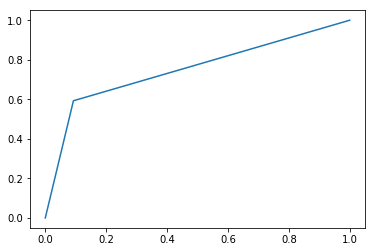

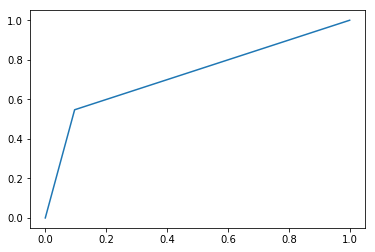

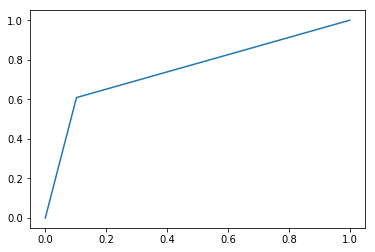

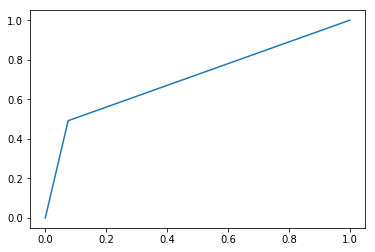

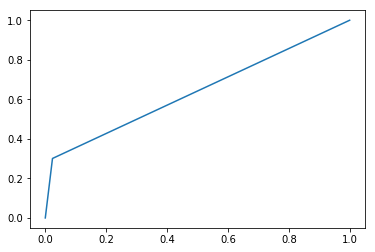

In [142]:
NBmodel30 = GaussianNB()
NBmodel1yr = GaussianNB()
X = data.drop(['thirty_days','one_year'],axis=1)
y30 = data[['thirty_days']].astype(int)
y1yr = data[['one_year']].astype(int)
# 30 days
Galpha = 1e-6
acc30 = [] 
auc30 = []
for t_in,v_in in skf.split(X,y30):
    Galpha = Galpha/10.0
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in].values.ravel()
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in].values.ravel()
    model = GaussianNB(var_smoothing=Galpha)
    model.fit(trainX,trainy)
    out = model.predict_proba(valX)
    fpr, tpr, thresholds = roc_curve(np.round(out[:,1]),valy.astype(bool))
    roc_auc = auc(fpr, tpr)
    plot.hist(out[:])
    auc30.append(roc_auc)
    acc30.append(model.score(valX,valy))
    plt.figure()
    plt.plot(fpr,tpr)
print(acc30)
print(auc30)
plt.show()

### Generate Complement Model and Fit Data

In [94]:
NBCmodel30 = ComplementNB(alpha = 3)
NBCmodel1yr = ComplementNB(alpha= 3)
NBCmodel30.fit(X_train,y_30day_train)
NBCmodel1yr.fit(X_train,y_1yr_train)

ComplementNB(alpha=3, class_prior=None, fit_prior=True, norm=False)

### Test Performance

In [95]:
print(NBmodel30.score(X_test,y_30day_test))
print(NBmodel1yr.score(X_test,y_1yr_test))

0.756896551724138
0.7424137931034482


In [96]:
print(NBCmodel30.score(X_test,y_30day_test))
print(NBCmodel1yr.score(X_test,y_1yr_test))

0.7757758620689655
0.7311206896551724


In [111]:
NBmodel30.predict_proba(X_test)

array([[1.00000000e+00, 2.82296731e-16],
       [9.74888813e-01, 2.51111871e-02],
       [1.00000000e+00, 3.73147843e-20],
       ...,
       [1.00000000e+00, 1.01875828e-11],
       [9.99998681e-01, 1.31912373e-06],
       [4.68841937e-03, 9.95311581e-01]])

# kNN

### Generate Model and Fit Data

In [112]:
KNmodel30 = KNeighborsRegressor()
KNmodel1yr =  KNeighborsRegressor()
KNmodel1yr.fit(X_train,y_1yr_train)
KNmodel30.fit(X_train,y_30day_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

### Test Performance

In [89]:
output = KNmodel30.predict_proba(X_test)

In [103]:
pd.DataFrame(output)[1].value_counts()

0.0    8828
0.2    1175
1.0     634
0.4     429
0.6     322
0.8     212
Name: 1, dtype: int64

In [78]:
KNmodel30.score(X_test,y_30day_test)

0.9216379310344828

In [79]:
KNmodel1yr.score(X_test,y_1yr_test)

0.8496551724137931

# XGboost